<div class="image">

  <img style="float: right;" src="https://storage.googleapis.com/kaggle-datasets-images/3660201/6354988/e36a3b89ed5cf6dde86c4e67d42b7b05/dataset-cover.png?t=2024-06-03-10-01-27" width="45%" align="right">
      <h4>
          <p style="font-size:20pt">MSIN0143: Programming for Business Analytics 24/25 Group Coursework</p>
          <p style="font-size:15pt">Applying Machine Learning to Cluster S&P 500 Companies Using ESG Risk Scores</p>
      </h4>
</div>
Team Code: T1<br/>
Team Names and Student Numbers:
<ul>
    <li>Tuhan Sapumanage - 24223873</li>
    <li>Ching-Ling Yu - 24145454</li>
    <li>Jianan Ni - 24069942</li>
    <li>Hengyu Zhai - 24113451</li>
</ul>

<style>
    body {
        font-family: 'Arial', sans-serif;
    }
    pre, code {
      white-space: pre-wrap;
      word-wrap: break-word;
      overflow-wrap: break-word;
    }
 
    table {
      width: 100%;
      table-layout: auto;
      word-wrap: break-word;
    }
 
    body {
      zoom: 80%;
    }
</style>

In [1]:
import nbformat
import re

# Get the current notebook's content
notebook_content = nbformat.read(open('MSIN0143-2024-GROUP-T1.ipynb', 'r'), as_version=4)

# Initialize word count and flags to control the counting range
word_count = 0
start_counting = False
stop_counting = False

# Iterate through cells in the notebook content
for cell in notebook_content['cells']:
    if cell['cell_type'] == 'markdown':
        # Check if the markdown cell contains the title "# Introduction and Business Case"
        if '# Introduction and Business Case' in cell['source']:
            start_counting = True  # Start counting after this section
        
        # Stop counting once we encounter the "# Appendix" section
        if '# References' in cell['source']:
            stop_counting = True
        
        # If we are in the desired section, count words
        if start_counting and not stop_counting:
            markdown_text = cell['source']
            words = re.findall(r'\b\w+\b', markdown_text)
            word_count += len(words)

# Print the word count
print(f"Total words from '# Introduction and Business Case' to before '# References', excluding in-text citations: {word_count}")

Total words from '# Introduction and Business Case' to before '# References', excluding in-text citations: 1991


# Table of Contents
1. [Introduction and Business Case](#Introduction-and-Business-Case)
2. [Importing and Cleaning Data](#Importing-and-Cleaning-Data)

   2.1 [Handling Missing Values](#Handling-Missing-Values)

   2.2 [Renaming Columns](#Renaming-Columns)
   
   2.3 [Type Conversion](#Type-Conversion)
   
   2.4 [Exploring Duplicates](#Exploring-Duplicates)
   
3. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-\(EDA\))

    3.1 [Distribution of the ESG Risk Scores](#Distribution-of-the-ESG-Risk-Scores)

    3.2 [Number of Companies (By Sector)](#Number-of-Companies-\(By-Sector\))

    3.3 [Average Total Risk Score (By Sector)](#Average-Total-Risk-Score-\(By-Sector\))
   
    3.4 [Correlation of Employee Count and Social Risk](#Correlation-of-Employee-Count-and-Social-Risk)

    3.5 [Correlation Matrix of Scores](#Correlation-Matrix-of-Scores)

4. [Feature Engineering](#Feature-Engineering)

    4.1 [Selecting Features for Analysis (After ML)](#Selecting-Features-for-Analysis-\(After-ML\))

    4.2 [Selecting Features for ML](#Selecting-Features-for-ML)

5. [Model Selection and Training](#Model-Selection-and-Training)

    5.1 [Why Machine Learning (ML)](#Why-Machine-Learning-\(ML\))

    5.2 [Algorithm Selection](#Algorithm-Selection)

    5.3 [Cluster Count Selection](#Cluster-Count-Selection)
   
    5.4 [K-Means with 105 Clusters](#K-Means-with-105-Clusters)

    5.5 [K-Means with 6 Clusters (from Elbow)](#K-Means-with-6-Clusters-\(from-Elbow\))

    5.6 [GMM with 105 Clusters](#GMM-with-105-Clusters)

    5.7 [GMM with 31 Clusters (from BIC)](#GMM-with-31-Clusters-\(from-BIC\))

    5.8 [Limitations](#Limitations)

6. [Performance Evaluation](#Performance-Evaluation)

    6.1 [Silhouette Score](#Performance-Evaluation)

    6.2 [Davies-Bouldin Score](#Performance-Evaluation)

    6.3 [Calinski-Harabasz Index](#Performance-Evaluation)

    6.4 [Visual Evaluations](#Visual-Evaluations)

7. [Data Visualisation for Chosen Clusters](#Data-Visualisation)

    7.1 [Big Picture of the Clusters](#Big-Picture-of-the-Clusters)

    7.2 [Clusters with Lowest Risk](#Clusters-with-Lowest-Risk)

    7.3 [Distribution of Companies (By Sector)](#Distribution-of-Companies-\(By-Sector\))

    7.4 [Distribution of Companies (By Industry)](#Distribution-of-Companies-\(By-Industry\))

    7.5 [Size of Companies (By Employee Count)](#Size-of-Companies-\(By-Employee-Count\))

    7.6 [Text Analysis of Descriptions of Companies](#Text-Analysis-of-Descriptions-of-Companies)

    7.7 [Variance Analysis of the Risk Scores](#Variance-Analysis-of-the-Risk-Scores)

8. [Conclusion and Next Steps](#Conclusion-and-Next-Steps)
9. [References](#References)
10. [Appendix](#Appendix)

    10.1 [Project Management](#Project-Management)
    
    10.2 [Use of Generative AI](#Use-of-Generative-AI)

# Introduction and Business Case

This project aims to cluster companies in the S&P 500 index based on their ESG (Environmental, Social and Governance) risk characteristics. The goal is to find a low-risk cluster of companies for which a hypothetical hedge fund could invest. The dataset with 2023 ratings from Sustainalytics, Inc. (a Morningstar company) was downloaded from Kaggle (Dugar, 2023). A sample of this dataset was cross-checked to verify the scores (Yahoo, 2024a; Yahoo, 2024b; Yahoo, 2024c).

# Importing and Cleaning Data

In [19]:
pip install wordcloud # Prerequisite for 'from wordcloud import WordCloud'

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd             # For data manipulation
import numpy as np              # For numerical operations

import matplotlib.pyplot as plt # For data visualisation
import seaborn as sns           # For statistical data visualisation
from scipy import stats         # For statistical functions
from scipy.stats import zscore  # For calculating Z-scores
from scipy.stats import skew    # For skewness
from sklearn.preprocessing import LabelEncoder  # For label encoding
from wordcloud import WordCloud  # For generating word clouds (needs pip install wordcloud)

from sklearn.cluster import KMeans  # For KMeans clustering algorithm
from sklearn.metrics import silhouette_score  # For evaluating clustering
from sklearn.decomposition import PCA  # For dimensionality reduction using PCA
from sklearn.mixture import GaussianMixture  # For Gaussian Mixture Model clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score # For evaluating model performance

In [6]:
# Set the seed for reproducibility
np.random.seed(1314)

# Read the CSV file and display top 5 rows
df_full = pd.read_csv('spdataset.csv')
df_full.head()

# Making a copy before starting manipulations 
df = df_full.copy()

### Handling Missing Values
Missing values were checked and handled by dropping rows with null values in any column. As the goal is to conduct clustering analysis (not say, regression), missing values were not replaced with calculated values such as the mean. A total of 400 companies remained in the dataset after this step.

In [10]:
# Check if there are any missing value
df.isnull().sum()

Symbol                      0
Name                        0
Address                     1
Sector                      1
Industry                    1
Full Time Employees         5
Description                 1
Total ESG Risk score       73
Environment Risk Score     73
Governance Risk Score      73
Social Risk Score          73
Controversy Level          73
Controversy Score         100
ESG Risk Percentile        73
ESG Risk Level             73
dtype: int64

In [12]:
# Drop any rows with missing values
df.dropna(inplace=True)
df.head()

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Level,Controversy Score,ESG Risk Percentile,ESG Risk Level
1,EMN,Eastman Chemical Company,"200 South Wilcox Drive\nKingsport, TN 37662\nU...",Basic Materials,Specialty Chemicals,"14,000",Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,Moderate Controversy Level,2.0,50th percentile,Medium
2,DPZ,Domino's Pizza Inc.,"30 Frank Lloyd Wright Drive\nAnn Arbor, MI 481...",Consumer Cyclical,Restaurants,"6,500","Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,Moderate Controversy Level,2.0,66th percentile,Medium
4,DVA,Davita Inc.,"2000 16th Street\nDenver, CO 80202\nUnited States",Healthcare,Medical Care Facilities,"70,000",DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,Moderate Controversy Level,2.0,38th percentile,Medium
5,DRI,"Darden Restaurants, Inc.","1000 Darden Center Drive\nOrlando, FL 32837\nU...",Consumer Cyclical,Restaurants,"187,384","Darden Restaurants, Inc., together with its su...",27.5,7.9,4.6,15.0,Moderate Controversy Level,2.0,59th percentile,Medium
6,ZTS,Zoetis Inc.,"10 Sylvan Way\nParsippany, NJ 07054\nUnited St...",Healthcare,Drug Manufacturers - Specialty & Generic,"14,100","Zoetis Inc. engages in the discovery, developm...",18.8,3.2,8.7,6.8,Moderate Controversy Level,2.0,23rd percentile,Low


In [14]:
df.isnull().sum() # Ensuring all missing values are droped

Symbol                    0
Name                      0
Address                   0
Sector                    0
Industry                  0
Full Time Employees       0
Description               0
Total ESG Risk score      0
Environment Risk Score    0
Governance Risk Score     0
Social Risk Score         0
Controversy Level         0
Controversy Score         0
ESG Risk Percentile       0
ESG Risk Level            0
dtype: int64

### Renaming Columns
Column names were edited to make them more machine-learning-friendly and to improve coding efficiency.

In [17]:
# Renaming to make columns shorter + remove blanks + lower case
df.rename(columns={
    'Symbol': 'symbol',
    'Name': 'name',
    'Address': 'address',
    'Sector': 'sector',
    'Industry': 'industry',
    'Full Time Employees': 'employee_count',
    'Description': 'desc',
    'Total ESG Risk score': 'total_risk',
    'Environment Risk Score': 'env_risk',
    'Governance Risk Score': 'gov_risk',
    'Social Risk Score': 'social_risk',
    'Controversy Level': 'con_level',
    'Controversy Score': 'con_score',
    'ESG Risk Percentile': 'risk_pnt',
    'ESG Risk Level': 'risk_level',
}, inplace=True)

df.info() # confirming the variables name has changed

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 502
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          400 non-null    object 
 1   name            400 non-null    object 
 2   address         400 non-null    object 
 3   sector          400 non-null    object 
 4   industry        400 non-null    object 
 5   employee_count  400 non-null    object 
 6   desc            400 non-null    object 
 7   total_risk      400 non-null    float64
 8   env_risk        400 non-null    float64
 9   gov_risk        400 non-null    float64
 10  social_risk     400 non-null    float64
 11  con_level       400 non-null    object 
 12  con_score       400 non-null    float64
 13  risk_pnt        400 non-null    object 
 14  risk_level      400 non-null    object 
dtypes: float64(5), object(10)
memory usage: 50.0+ KB


### Type Conversion
The columns storing numeric values that were in string format (e.g.: comma-separated numbers) were converted from strings to integers.

In [20]:
# Remove commas and convert employee_count from string to integers 
df['employee_count'] = df['employee_count'].str.replace(',', '')  # Remove commas
df['employee_count'] = pd.to_numeric(df['employee_count'], errors='coerce', downcast='float')  # Convert to integers

# Verify the transformation
print(df['employee_count'].head())  # Check the first few values
print(df['employee_count'].dtype)  # Ensure the column is now integers
df.info() # No value was lost

1     14000.0
2      6500.0
4     70000.0
5    187384.0
6     14100.0
Name: employee_count, dtype: float32
float32
<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 502
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          400 non-null    object 
 1   name            400 non-null    object 
 2   address         400 non-null    object 
 3   sector          400 non-null    object 
 4   industry        400 non-null    object 
 5   employee_count  400 non-null    float32
 6   desc            400 non-null    object 
 7   total_risk      400 non-null    float64
 8   env_risk        400 non-null    float64
 9   gov_risk        400 non-null    float64
 10  social_risk     400 non-null    float64
 11  con_level       400 non-null    object 
 12  con_score       400 non-null    float64
 13  risk_pnt        400 non-null    object 
 14  risk_level      400 non-null    object 
dtypes: float32(1), 

### Exploring Duplicates
The dataset was checked for duplicates, but none were found.

In [23]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 502
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          400 non-null    object 
 1   name            400 non-null    object 
 2   address         400 non-null    object 
 3   sector          400 non-null    object 
 4   industry        400 non-null    object 
 5   employee_count  400 non-null    float32
 6   desc            400 non-null    object 
 7   total_risk      400 non-null    float64
 8   env_risk        400 non-null    float64
 9   gov_risk        400 non-null    float64
 10  social_risk     400 non-null    float64
 11  con_level       400 non-null    object 
 12  con_score       400 non-null    float64
 13  risk_pnt        400 non-null    object 
 14  risk_level      400 non-null    object 
dtypes: float32(1), float64(5), object(9)
memory usage: 48.4+ KB


# Exploratory Data Analysis (EDA)
### Distribution of the ESG Risk Scores
The ESG risk scores were analysed to understand the distribution and identify outliers. However, outliers were retained as they would naturally cluster separately (more in the section on Limitations), unlike in regression, where they introduce noise.
<ul>
  <li>No outliers in the total ESG risk scores.</li>
  <li>Four outliers in governance risk scores.</li>
  <li>Three outliers each in environmental and social risk scores.</li>
</ul>
<p>It was also observed that all risk score distributions are right-skewed indicating that the majority of the companies have low risk scores with a few companies having somewhat higher risk scores.</p>

Note: These scores start from zero and go on an open-ended scale. The risk score intervals are 0-0.99, 10-19.99, 20-29.99, 30-39.99 and 40+ for negligible, low, medium, high and severe risk (Karoui and Zerter, 2023).

In [26]:
# Risk columns extracted to check outliers
risk_columns = ['total_risk', 'env_risk', 'social_risk', 'gov_risk']

# Converting the risk scores to Z-scores
for column in risk_columns:
    # Calculate Z-scores for the chosen column
    df['z_score'] = zscore(df[column])
    
    # Filter for outliers where the absolute Z-score is above 3
    outliers = df[df['z_score'].abs() > 3]
    
    # Select specific columns to print
    if not outliers.empty:
        print(f"Outliers based on Z-score for {column}:\n")
        print(outliers[['name', 'sector', column]], "\n")
    else:
        print(f"No outliers found for {column}.\n")
    
    # Drop the Z-score column afterward
    df.drop(columns=['z_score'], inplace=True)

No outliers found for total_risk.

Outliers based on Z-score for env_risk:

                                 name  sector  env_risk
166  Occidental Petroleum Corporation  Energy      25.0
324           Exxon Mobil Corporation  Energy      23.1
465                   Apa Corporation  Energy      22.0 

Outliers based on Z-score for social_risk:

                                        name                  sector  \
42   Universal Health Services, Inc. Class B              Healthcare   
205             Meta Platforms, Inc. Class A  Communication Services   
434                           Boeing Company             Industrials   

     social_risk  
42          20.7  
205         21.1  
434         22.5   

Outliers based on Z-score for gov_risk:

                           name              sector  gov_risk
20            Wells Fargo & Co.  Financial Services      19.4
220              M&t Bank Corp.  Financial Services      13.6
393              Citigroup Inc.  Financial Services      13.

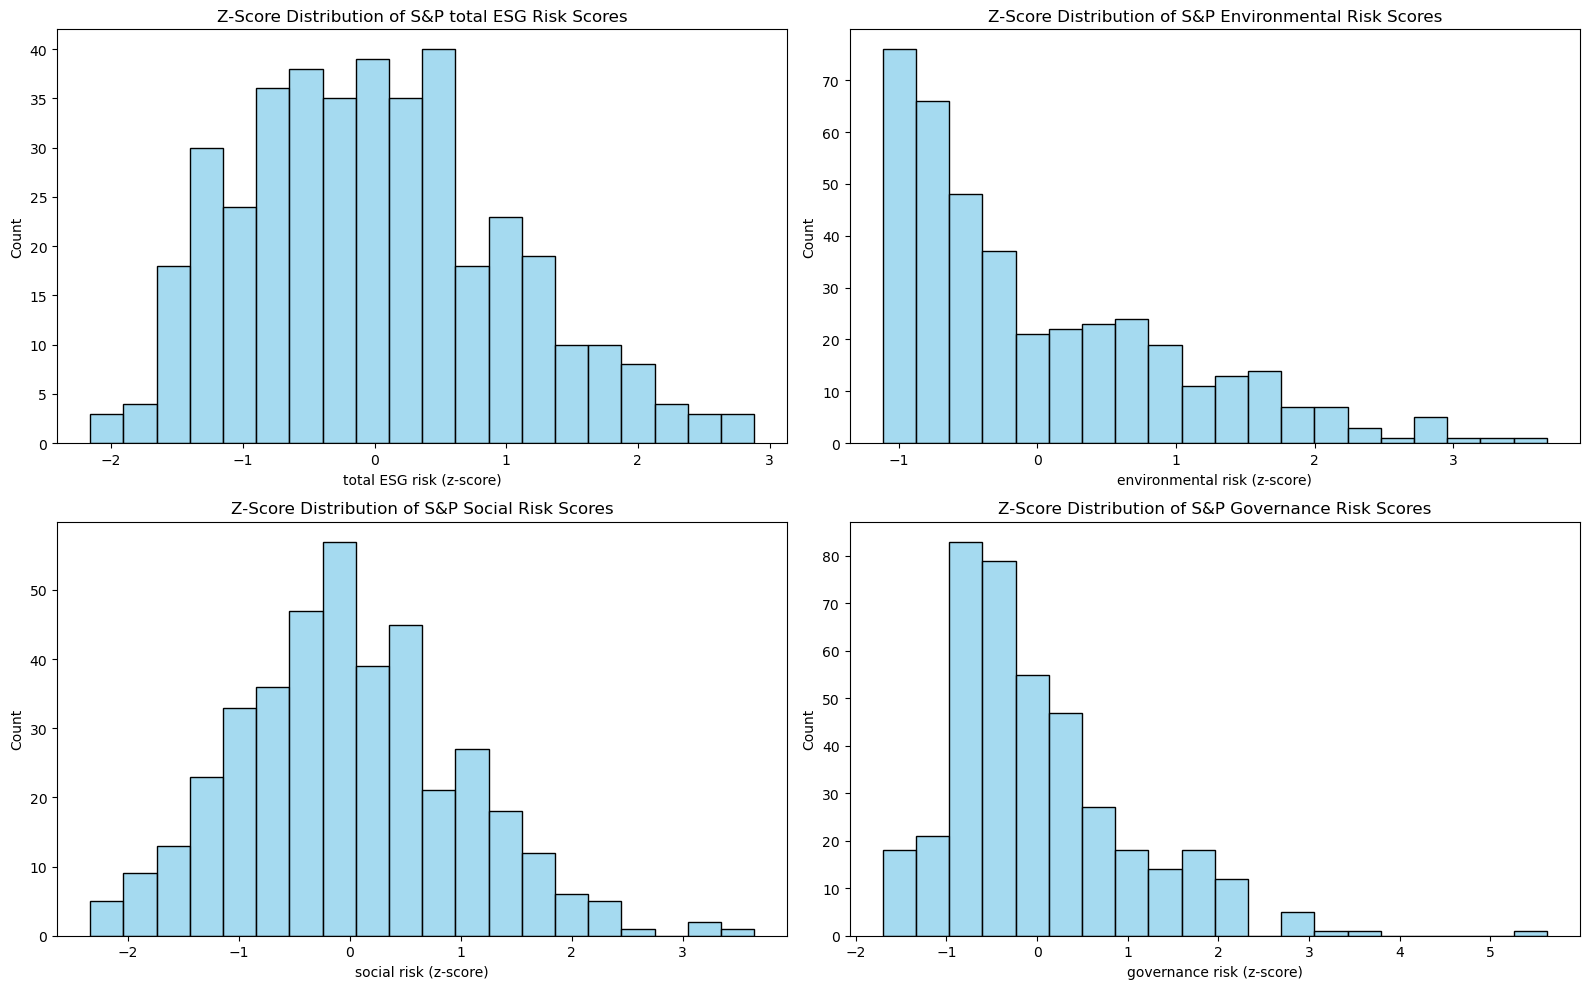

In [28]:
#df_z created to avoid manipulating the main df
df_z = df.copy()

# Calculate Z-scores for each column
df_z['total_risk_z'] = (df_z['total_risk'] - df_z['total_risk'].mean()) / df_z['total_risk'].std()
df_z['env_risk_z'] = (df_z['env_risk'] - df_z['env_risk'].mean()) / df_z['env_risk'].std()
df_z['social_risk_z'] = (df_z['social_risk'] - df_z['social_risk'].mean()) / df_z['social_risk'].std()
df_z['gov_risk_z'] = (df_z['gov_risk'] - df_z['gov_risk'].mean()) / df_z['gov_risk'].std()

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Total ESG Z-Score Distribution
sns.histplot(df_z['total_risk_z'], bins=20, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_xlabel('total ESG risk (z-score)')
axes[0, 0].set_title('Z-Score Distribution of S&P total ESG Risk Scores')

# Plot 2: Environmental Z-Score Distribution
sns.histplot(df_z['env_risk_z'], bins=20, color='skyblue', ax=axes[0, 1])
axes[0, 1].set_xlabel('environmental risk (z-score)')
axes[0, 1].set_title('Z-Score Distribution of S&P Environmental Risk Scores')

# Plot 3: Social Z-Score Distribution
sns.histplot(df_z['social_risk_z'], bins=20, color='skyblue', ax=axes[1, 0])
axes[1, 0].set_xlabel('social risk (z-score)')
axes[1, 0].set_title('Z-Score Distribution of S&P Social Risk Scores')

# Plot 4: Governance Z-Score Distribution
sns.histplot(df_z['gov_risk_z'], bins=20, color='skyblue', ax=axes[1, 1])
axes[1, 1].set_xlabel('governance risk (z-score)')
axes[1, 1].set_title('Z-Score Distribution of S&P Governance Risk Scores')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [29]:
# Calculate mean, median, and skewness for each column
summary_stats = pd.DataFrame({
    'Mean': df_z[risk_columns].mean(),
    'Median': df_z[risk_columns].median(),
    'Skewness': df_z[risk_columns].apply(lambda x: skew(x, nan_policy='omit'))
})

# Add a column to classify the skewness
summary_stats['Skewness Direction'] = summary_stats['Skewness'].apply(lambda x: 'Right' if x > 0 else ('Left' if x < 0 else 'Symmetrical'))
print(summary_stats)

                 Mean  Median  Skewness Skewness Direction
total_risk   21.91175    21.4  0.400054              Right
env_risk      5.82500     4.1  1.026457              Right
social_risk   9.27575     9.1  0.354536              Right
gov_risk      6.81325     6.2  1.296621              Right


### Number of Companies (By Sector)
A bar chart can be used to visualise the sectors companies in the index belong to. The number of companies in the 'Financial Services' sector (62) and 'Industrials' sector (57) is significantly higher, while the 'Communication Services' sector (14) and 'Basic Materials' sector (19) have noticeably fewer companies. This was to understand the industry makeup before visualising the sector-specific average ESG risk scores. 

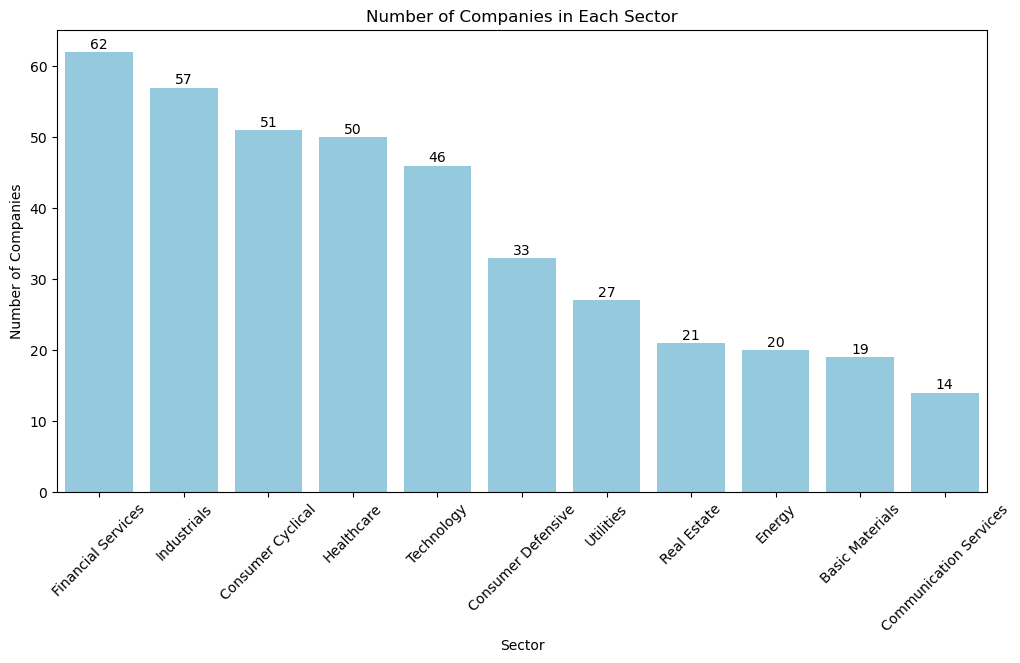

In [33]:
# Count the number of companies in each sector
sector_counts = df['sector'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values, color='skyblue')

# Add values on top of each bar
for index, value in enumerate(sector_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', fontsize=10, color='black')

# Customise the plot
plt.xlabel('Sector')
plt.ylabel('Number of Companies')
plt.title('Number of Companies in Each Sector')
plt.xticks(rotation=45)
plt.show()

### Average Total Risk Score (By Sector)
Industries such as 'Energy', 'Utilities', and 'Basic Materials' exhibit higher ESG risk scores, possibly due to their traditional nature, inefficiencies in operations and governance, and significant environmental risks. On the other hand, industries such as 'Real Estate', 'Technology', 'Consumer Cyclical', and 'Communication Services' show lower ESG risks, likely because of their smaller environmental footprint, stronger innovation, and rapid development.

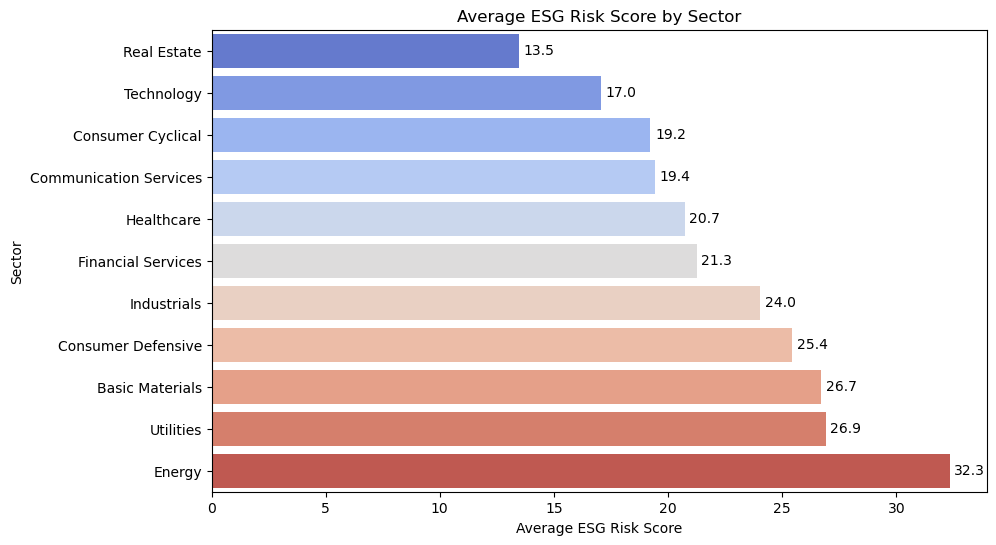

In [36]:
# Calculate average ESG score for each sector
avg_esg_scores = df.groupby('sector')['total_risk'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_esg_scores.values, y=avg_esg_scores.index, hue=avg_esg_scores.index, palette='coolwarm', legend=False)

# Add values to the right of each bar
for index, value in enumerate(avg_esg_scores.values):
    plt.text(value + 0.2, index, f'{value:.1f}', va='center', fontsize=10, color='black')

# Customize the plot
plt.xlabel('Average ESG Risk Score')
plt.ylabel('Sector')
plt.title('Average ESG Risk Score by Sector')
plt.show()

### Correlation Matrix of Scores
A heatmap was used to display the correlation matrix between total risk and its three components: environmental risk, social risk and governance risk. The goal is to understand what drives the total risk the most.

In the heatmap, total risk shows a strong positive correlation with environmental risk (0.71) and social risk (0.68), indicating that environmental and social risks are key drivers of total risk. Another minor observation is the weak negative correlation (-0.24) between environmental risk and governance risk, potentially because as the environmental risk increases, companies are preparing to tackle the same with stronger governance, reducing the governance risk.

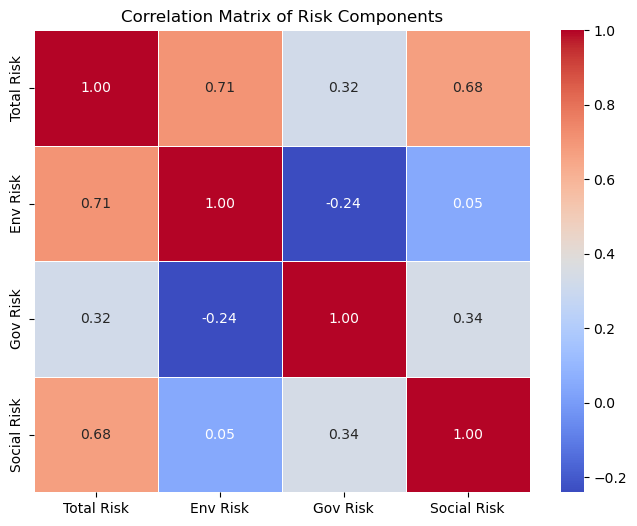

In [39]:
# Calculate the correlation matrix
correlation_matrix = df[['total_risk', 'env_risk', 'gov_risk', 'social_risk']].corr()

# Create a custom list of labels
labels = ['Total Risk', 'Env Risk', 'Gov Risk', 'Social Risk']

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, xticklabels=labels, yticklabels=labels)
plt.title('Correlation Matrix of Risk Components')
plt.show()

### Correlation of Employee Count and Social Risk
Lastly, a scatter plot was created to examine the relationship between employee count and social risk. The employee count was log-transformed to improve readability and reduce distortion from outliers. The goal was to explore any correlation between the two variables. The scatter plot revealed a slight positive slope in the regression line, suggesting that as the employee count increases, social risk also tends to rise. This indicates that companies with more employees may face slightly higher social risks, potentially due to greater public attention, workforce diversity, or exposure to social issues.

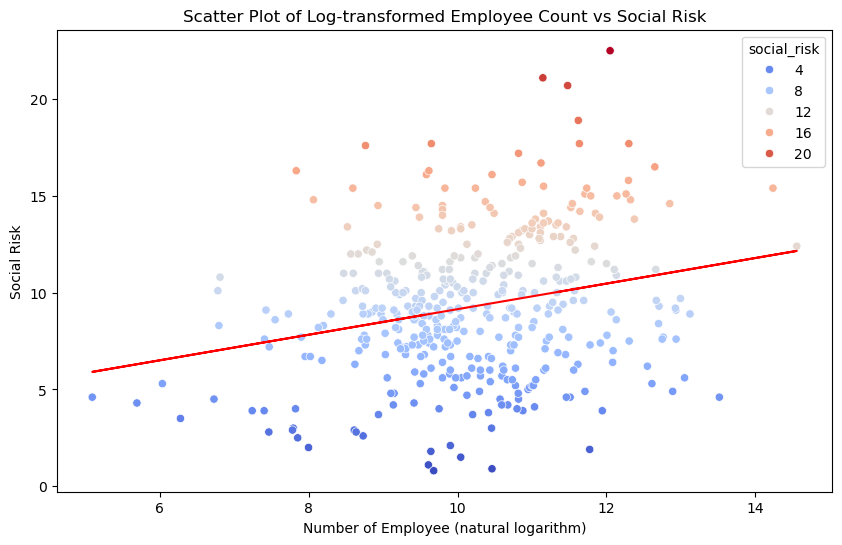

In [42]:
# Scatter plot for employee count vs. social risk (with regression line)
plt.figure(figsize=(10, 6))

# Apply natural log to employee numbers to reduce the influence of outliers
log_x_values = np.log(df['employee_count'])
y_values = df['social_risk']

sns.scatterplot(x=log_x_values, y=y_values, data=df, hue='social_risk', palette='coolwarm')

# Perform linear regression
coefficients = np.polyfit(log_x_values, y_values, 1)  # 1 for linear regression
slope, intercept = coefficients

# Generate regression line
regression_line = slope * log_x_values + intercept

# plot the regression line
plt.plot(log_x_values, regression_line, color="red", label="Regression line")


plt.xlabel('Number of Employee (natural logarithm)')
plt.ylabel('Social Risk')
plt.title('Scatter Plot of Log-transformed Employee Count vs Social Risk')
plt.show()

# Feature Engineering

### Selecting Features for Analysis (After ML)

Irrelevant variables for clustering (e.g., <code>address</code>) and redundant variables already captured in numerical ones (e.g., <code>risk_level</code>, which is reflected in the risk scores) were removed to create <code>df_clean</code>. This dataset will be used to append the selected clusters.

<code>df_ml</code> was derived from <code>df_clean</code>, resulting in a more refined, machine learning-friendly dataset. In <code>df_ml</code>, sector labels are encoded to convert categorical data into numerical values. Additionally, numerical variables are standardised to z-scores to prevent clustering algorithms from giving undue weight to variables with larger values (such as employee count).

In [63]:
df_clean = df.drop(
    ['name',
     'address',
     'risk_pnt',
     'con_level',
     'risk_level'], axis = 1)
df_clean.head()

,symbol,sector,industry,employee_count,desc,total_risk,env_risk,gov_risk,social_risk,con_score
1,EMN,Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,2.0
2,DPZ,Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,2.0
4,DVA,Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,2.0
5,DRI,Consumer Cyclical,Restaurants,187384.0,"Darden Restaurants, Inc., together with its su...",27.5,7.9,4.6,15.0,2.0
6,ZTS,Healthcare,Drug Manufacturers - Specialty & Generic,14100.0,"Zoetis Inc. engages in the discovery, developm...",18.8,3.2,8.7,6.8,2.0


### Selecting Features for ML

In [66]:
# Drop additional irrelevant or redundant columns from the cleaned dataset
df_ml = df_clean.drop(
    ['symbol',     # Non-numerical column
     'industry',      # Categorical column - note, below
     'desc',          # Descriptive column
     'total_risk'],   # Redundant column
    axis=1           # Specify axis=1 to indicate column removal
) # industry is too granular, disrupting clusters. Sector (encoded below) was used instead.

# Initialise the LabelEncoder for encoding categorical data
le = LabelEncoder()

# Fit the LabelEncoder on the 'sector' column to learn the unique categories
le.fit(df_ml['sector'])

# Transform the 'sector' column from categorical data to numerical labels
df_ml['sector'] = le.transform(df_ml['sector'])

# Standardise numerical columns using Z-score for consistent scaling
# Avoided using the Z-scores created in EDA for df_z for a modular, cleaner code flow
df_ml['sector'] = stats.zscore(df_ml['sector'])
df_ml['employee_count'] = stats.zscore(df_ml['employee_count'])
df_ml['env_risk'] = stats.zscore(df_ml['env_risk'])
df_ml['gov_risk'] = stats.zscore(df_ml['gov_risk'])
df_ml['social_risk'] = stats.zscore(df_ml['social_risk'])
df_ml['con_score'] = stats.zscore(df_ml['con_score'])

# Display the first 5 rows of the standardised dataset
df_ml.head()

,sector,employee_count,env_risk,gov_risk,social_risk,con_score
1,-1.927719,-0.344111,1.339002,-0.095384,-0.959422,-0.01265
2,-1.212424,-0.393066,0.916664,-0.229569,0.807190,-0.01265
4,0.218165,0.021418,-1.099037,0.709730,1.331653,-0.01265
5,-1.212424,0.787621,0.398341,-0.989954,1.580083,-0.01265
6,0.218165,-0.343459,-0.503925,0.843915,-0.683389,-0.01265


# Model Selection and Training

### Why Machine Learning (ML)
The goal of the machine learning task was to find a cluster of companies with low ESG risk scores for a hypothetical hedge fund to invest in. The four models developed go beyond merely sorting from the <code>total_risk</code> column. They factor in the sector, employee count (thus, size), controversy score and the three risk scores across environmental, social and governance dimensions.

### Algorithm Selection
Given the 400-500 companies, an algorithm that allows specifying the number of clusters was necessary to achieve small cluster sizes. Among such algorithms, K-Means was the clear choice due to its popularity and widespread use (Babitz, 2023). The second model, the Gaussian Mixture Model (GMM), was selected because it offers a different approach compared to K-Means (unlike K-Medoids), which could provide unique clusters for comparison during the evaluation stage (VanderPlas, 2019).

### Cluster Count Selection
For K-Means, the silhouette method was used to determine the optimal number of clusters, with the range set from 2 to 400 to test all possible values and identify the most suitable one. This resulted in 105 clusters. For thoroughness, the elbow method (for K-Means) and the Bayesian Information Criterion (BIC) (for GMM) were also applied. This approach led to four unique models from the two selected algorithms, as outlined below.

- K-means with 105 clusters
- K-means with 6 clusters (elbow method)
- GMM with 105 clusters
- GMM with 31 clusters (BIC)

In [ ]:
###
###
### WARNING: BELOW CELLS (NEXT 3) ARE COMPUTE-HEAVY AND TAKES A WHILE TO RUN ###
### WARNING: BELOW CELLS (NEXT 3) ARE COMPUTE-HEAVY AND TAKES A WHILE TO RUN ###
### WARNING: BELOW CELLS (NEXT 3) ARE COMPUTE-HEAVY AND TAKES A WHILE TO RUN ###
###
###

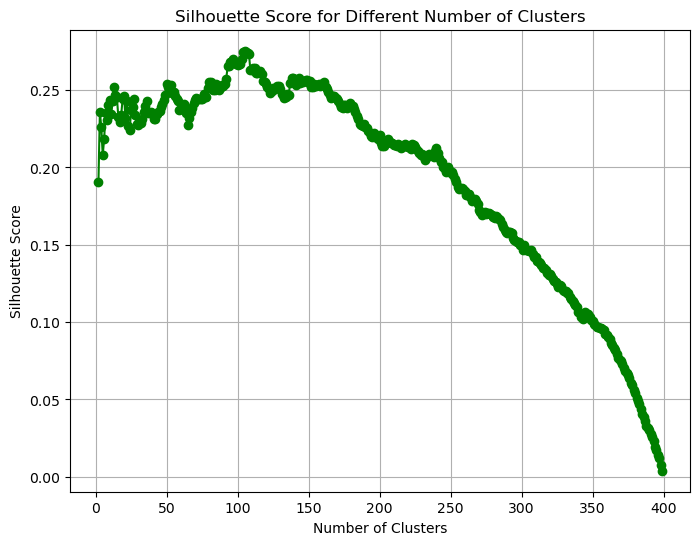

Optimal number of clusters according to Silhouette Score: 105


In [71]:
# Cluster count to be used for both K-means and GMM
# Range of cluster numbers to try
n_clusters_range = range(2, 400)  # Try from 2 to 400 clusters

# List to store silhouette scores for each k
sil_scores = []

# Fit K-Means and calculate silhouette score for each k
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_ml)
    
    # Calculate Silhouette Score
    sil_score = silhouette_score(df_ml, kmeans.labels_)
    sil_scores.append(sil_score)

# Plotting the Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, sil_scores, marker='o', color='g')
plt.title('Silhouette Score for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Finding the optimal number of clusters
optimal_clusters_silhouette = n_clusters_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters according to Silhouette Score: {optimal_clusters_silhouette}")

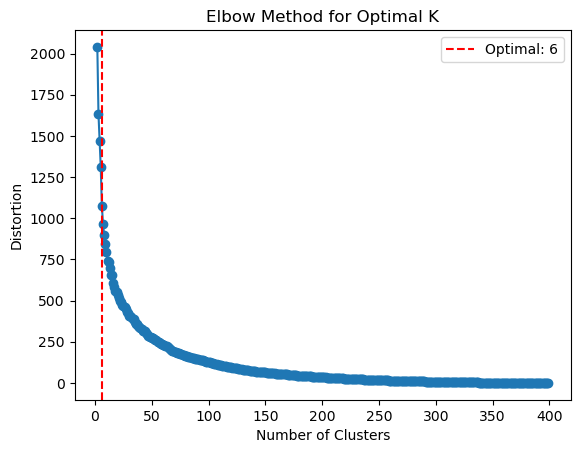

Optimal number of clusters (Elbow Method): 6


In [72]:
# Cluster count to be used for K-Means only
# Initialise the list to store distortions (inertia - cluster compactness measurement score)
distortions = []
cluster_range = range(2, 400)  # Range of clusters to test

# Calculate distortions for each value of k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(df_ml)
    distortions.append(kmeans.inertia_)

# Find the optimal number of clusters (elbow point)
# Using the second derivative to find where the curve flattens (elbow)
diff = np.diff(distortions)
second_diff = np.diff(diff)
optimal_k_elbow = cluster_range[2 + np.argmax(second_diff < 0)]  # First index where second diff is negative

# Plot the Elbow Curve
plt.plot(cluster_range, distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.axvline(optimal_k_elbow, color='red', linestyle='--', label=f'Optimal: {optimal_k_elbow}')
plt.legend()
plt.show()

# Print the optimal number of clusters
print(f"Optimal number of clusters (Elbow Method): {optimal_k_elbow}")

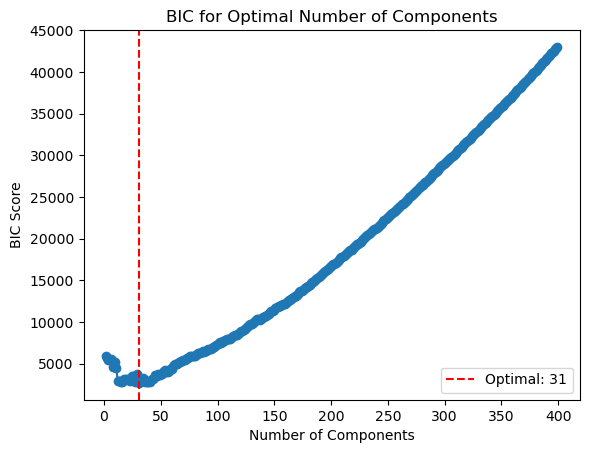

Optimal number of clusters (BIC): 31


In [73]:
# Cluster count to be used for GMM only
bic_scores = []
cluster_range = range(2, 400)  # Range of clusters to test

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_ml)
    bic_scores.append(gmm.bic(df_ml))

# Find the optimal number of clusters
optimal_k_bic = cluster_range[np.argmin(bic_scores)]  # Index of minimum BIC score

# Plot the BIC curve
plt.plot(cluster_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC for Optimal Number of Components')
plt.axvline(optimal_k_bic, color='red', linestyle='--', label=f'Optimal: {optimal_k_bic}')
plt.legend()
plt.show()

# Print the optimal number of clusters
print(f"Optimal number of clusters (BIC): {optimal_k_bic}")

### K-Means with 105 Clusters

In [75]:
# Initialise KMeans with 105 clusters, fixed random state, and auto initialisation
kmeans105 = KMeans(n_clusters=105, random_state=0, n_init='auto')

# Fit the KMeans model to the data
kmeans105.fit(df_ml)

# Assign the cluster labels to a new column in the dataframe
df_clean['k-means_105'] = kmeans105.labels_

# Display the first few rows of the updated dataframe
df_clean.head()

,symbol,sector,industry,employee_count,desc,total_risk,env_risk,gov_risk,social_risk,con_score,k-means_105
1,EMN,Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,2.0,38
2,DPZ,Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,2.0,4
4,DVA,Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,2.0,17
5,DRI,Consumer Cyclical,Restaurants,187384.0,"Darden Restaurants, Inc., together with its su...",27.5,7.9,4.6,15.0,2.0,70
6,ZTS,Healthcare,Drug Manufacturers - Specialty & Generic,14100.0,"Zoetis Inc. engages in the discovery, developm...",18.8,3.2,8.7,6.8,2.0,83


### K-Means with 6 Clusters (from Elbow)

In [77]:
# Initialise KMeans with 6 clusters, fixed random state, and auto initialisation
kmeans = KMeans(n_clusters=6, random_state=0, n_init='auto')

# Fit the KMeans model to the data
kmeans.fit(df_ml)

# Assign the cluster labels to a new column in the dataframe
df_clean['k-means_cluster'] = kmeans.labels_

# Display the first few rows of the updated dataframe
df_clean.head()

,symbol,sector,industry,employee_count,desc,total_risk,env_risk,gov_risk,social_risk,con_score,k-means_105,k-means_cluster
1,EMN,Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,2.0,38,2
2,DPZ,Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,2.0,4,2
4,DVA,Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,2.0,17,0
5,DRI,Consumer Cyclical,Restaurants,187384.0,"Darden Restaurants, Inc., together with its su...",27.5,7.9,4.6,15.0,2.0,70,2
6,ZTS,Healthcare,Drug Manufacturers - Specialty & Generic,14100.0,"Zoetis Inc. engages in the discovery, developm...",18.8,3.2,8.7,6.8,2.0,83,0


### GMM with 105 Clusters

In [79]:
# Initialise Gaussian Mixture Model with 105 components and fixed random state
gmm105 = GaussianMixture(n_components=105, random_state=42)

# Fit the GMM model to the data
gmm105.fit(df_ml)

# Predict the cluster labels using the fitted model
cluster_labels = gmm105.predict(df_ml)

# Assign the cluster labels to a new column in the dataframe
df_clean['gmm_105'] = cluster_labels

# Display the first few rows of the updated dataframe
df_clean.head()

,symbol,sector,industry,employee_count,desc,total_risk,env_risk,gov_risk,social_risk,con_score,k-means_105,k-means_cluster,gmm_105
1,EMN,Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,2.0,38,2,42
2,DPZ,Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,2.0,4,2,86
4,DVA,Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,2.0,17,0,19
5,DRI,Consumer Cyclical,Restaurants,187384.0,"Darden Restaurants, Inc., together with its su...",27.5,7.9,4.6,15.0,2.0,70,2,1
6,ZTS,Healthcare,Drug Manufacturers - Specialty & Generic,14100.0,"Zoetis Inc. engages in the discovery, developm...",18.8,3.2,8.7,6.8,2.0,83,0,22


### GMM with 31 Clusters (from BIC)

In [81]:
# Initialise Gaussian Mixture Model with 31 components and fixed random state
gmm = GaussianMixture(n_components=31, random_state=42)

# Fit the GMM model to the data
gmm.fit(df_ml)

# Predict the cluster labels using the fitted model
cluster_labels = gmm.predict(df_ml)

# Assign the cluster labels to a new column in the dataframe
df_clean['gmm_cluster'] = cluster_labels

# Display the first few rows of the updated dataframe
df_clean.head()

,symbol,sector,industry,employee_count,desc,total_risk,env_risk,gov_risk,social_risk,con_score,k-means_105,k-means_cluster,gmm_105,gmm_cluster
1,EMN,Basic Materials,Specialty Chemicals,14000.0,Eastman Chemical Company operates as a special...,25.3,12.8,6.6,5.8,2.0,38,2,42,5
2,DPZ,Consumer Cyclical,Restaurants,6500.0,"Domino's Pizza, Inc., through its subsidiaries...",29.2,10.6,6.3,12.2,2.0,4,2,86,22
4,DVA,Healthcare,Medical Care Facilities,70000.0,DaVita Inc. provides kidney dialysis services ...,22.6,0.1,8.4,14.1,2.0,17,0,19,3
5,DRI,Consumer Cyclical,Restaurants,187384.0,"Darden Restaurants, Inc., together with its su...",27.5,7.9,4.6,15.0,2.0,70,2,1,1
6,ZTS,Healthcare,Drug Manufacturers - Specialty & Generic,14100.0,"Zoetis Inc. engages in the discovery, developm...",18.8,3.2,8.7,6.8,2.0,83,0,22,3


### Limitations
K-means assumes that each cluster is spherical (points within the cluster are evenly distributed) and equally sized. As seen with the results below, this is not the case when 105 clusters are used. Although not as sensitive as regression models, k-means can be somewhat sensitive to outliers potentially distorting the mean of a cluster. However, using a large number of clusters reduces the impact of this issue.

GMM assumes the data follows a normal distribution, which is not fully satisfied by our dataset (slightly right skewed, as seen in the section on EDA). GMM can be sensitive to outliers but is less sensitive to outliers because it merely assigns a low probability of belonging to a cluster for a single point rather than influencing the entire cluster.

Both clustering algorithms are sensitive to the initial starting points (in K-means, called centroids) and it may need to experiment with multiple <code>random_state</code> values to find the optimal starting points. 

# Performance Evaluation

### Silhouette, Davies-Bouldin and Calinski-Harabasz
The four models were evaluated for its Silhouette Score, Davies-Bouldin Score and Calinski-Harabasz Index. These metrics were chosen as the dataset lacks existing 'true' labels to compare the predictions from ML (Yang, 2017; Ullah et al., 2023).

These compare how well the points within a single cluster are related and how distant each point/cluster is from others. They <i>can</i> be used to objectively evaluate the performance (like R2 in regression) but are more useful when compared between models, selecting the following.

- Silhouette Score (higher is better): GMM and k-means 105 clusters
- Davies-Bouldin Score (lower is better): k-means 105 clusters
- Calinski-Harabasz Index (higher is better): k-means with 6 clusters

Based on this evaluation, k-means can be chosen as they rank high in 3/3 indicators, and k-means with 105 rank high in 2/3 criteria. The data was appended to the <code>df_clean</code> for overall visualisations and <code>df_chosen</code> for the final set of stock symbols chosen.

### Visual Evaluations
In addition to these metrics Silhouette Score, Elbow Method and BIC can be used to evaluate if the models yield the best potential number of clusters. It was added in the ML section for a better flow of the document.

In [86]:
# Evaluate K-Means 105
kmeans_105_silhouette = silhouette_score(df_ml, df_clean['k-means_105'])
kmeans_105_davies_bouldin = davies_bouldin_score(df_ml, df_clean['k-means_105'])
kmeans_105_calinski_harabasz = calinski_harabasz_score(df_ml, df_clean['k-means_105'])

# Evaluate K-Means 6
kmeans_silhouette = silhouette_score(df_ml, df_clean['k-means_cluster'])
kmeans_davies_bouldin = davies_bouldin_score(df_ml, df_clean['k-means_cluster'])
kmeans_calinski_harabasz = calinski_harabasz_score(df_ml, df_clean['k-means_cluster'])

# Evaluate GMM 105
gmm_105_silhouette = silhouette_score(df_ml, df_clean['gmm_105'])
gmm_105_davies_bouldin = davies_bouldin_score(df_ml, df_clean['gmm_105'])
gmm_105_calinski_harabasz = calinski_harabasz_score(df_ml, df_clean['gmm_105'])

# Evaluate GMM 31
gmm_silhouette = silhouette_score(df_ml, df_clean['gmm_cluster'])
gmm_davies_bouldin = davies_bouldin_score(df_ml, df_clean['gmm_cluster'])
gmm_calinski_harabasz = calinski_harabasz_score(df_ml, df_clean['gmm_cluster'])

# Display results
print("Evaluation of Clustering Algorithms:")
print("K-Means Clustering with 105:")
print(f"105 Silhouette Score: {kmeans_105_silhouette:.4f}")
print(f"105 Davies-Bouldin Score: {kmeans_105_davies_bouldin:.4f}")
print(f"105 Calinski-Harabasz Index: {kmeans_105_calinski_harabasz:.4f}")

print("\nK-Means Clustering with 6:")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Score: {kmeans_davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {kmeans_calinski_harabasz:.4f}")

print("\nGaussian Mixture Model (GMM) with 105:")
print(f"105 Silhouette Score: {gmm_105_silhouette:.4f}")
print(f"105 Davies-Bouldin Score: {gmm_105_davies_bouldin:.4f}")
print(f"105 Calinski-Harabasz Index: {gmm_105_calinski_harabasz:.4f}")

print("\nGaussian Mixture Model (GMM) with 31:")
print(f"Silhouette Score: {gmm_silhouette:.4f}")
print(f"Davies-Bouldin Score: {gmm_davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {gmm_calinski_harabasz:.4f}")

Evaluation of Clustering Algorithms:
K-Means Clustering with 105:
105 Silhouette Score: 0.2741
105 Davies-Bouldin Score: 0.7356
105 Calinski-Harabasz Index: 55.2963

K-Means Clustering with 6:
Silhouette Score: 0.2339
Davies-Bouldin Score: 1.1772
Calinski-Harabasz Index: 96.9639

Gaussian Mixture Model (GMM) with 105:
105 Silhouette Score: 0.2754
105 Davies-Bouldin Score: 0.8016
105 Calinski-Harabasz Index: 55.3266

Gaussian Mixture Model (GMM) with 31:
Silhouette Score: 0.1535
Davies-Bouldin Score: 1.4008
Calinski-Harabasz Index: 41.9304


## Data Visualisation

### Big Picture of the Clusters

The first visualisation presents the number of companies in each cluster based on the 105 k-means clusters. All clusters are visualised for reference. The stock symbols belonging to each cluster are listed below as well.

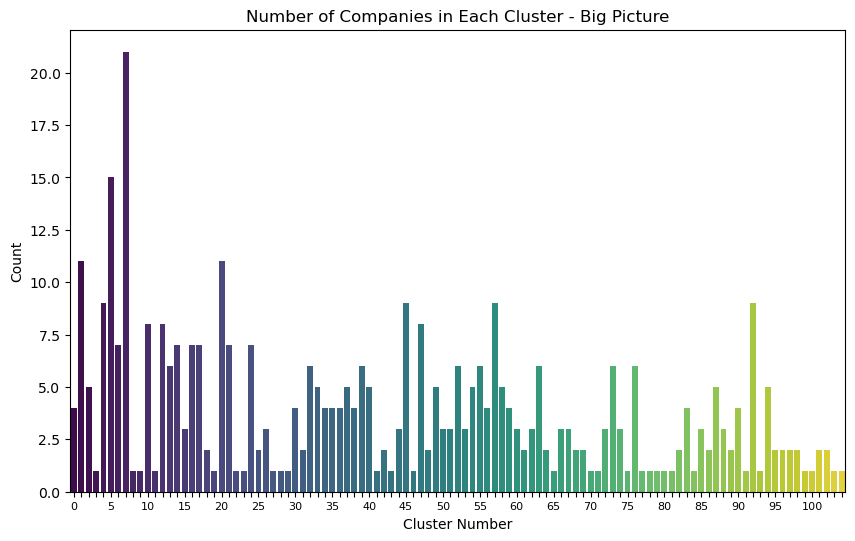

In [335]:
# Set the size of the figure (10 inches wide, 6 inches high)
plt.figure(figsize=(10, 6))

# Create a count plot to show the distribution of stock symbols in clusters
# 'df_clean' is the data, 'k-means_105' is the column with cluster labels
# 'hue' is used to color the bars by the 'k-means_105' cluster labels
sns.countplot(data=df_clean, x='k-means_105', hue='k-means_105', palette='viridis', legend=False)

# Add a title to the plot
plt.title('Number of Companies in Each Cluster - Big Picture')

# Label the x-axis
plt.xlabel('Cluster Number')

# Reduce the number of x-axis labels
# Get all unique cluster labels
unique_clusters = sorted(df_clean['k-means_105'].unique())

# Select every nth label to display
n = 5  # Change this value to control frequency
selected_labels = [label if idx % n == 0 else '' for idx, label in enumerate(unique_clusters)]
plt.xticks(ticks=range(len(unique_clusters)), labels=selected_labels, fontsize=8)

# Label the y-axis
plt.ylabel('Count')

# Display the plot
plt.show()

In [281]:
# Group data by cluster and list the symbols in each cluster
clustered_symbols = df_clean.groupby('k-means_105')['symbol'].apply(list)

# Loop through each cluster and print the symbols in that cluster
for cluster, symbols in clustered_symbols.items():
    print(f"Cluster {cluster}: {', '.join(symbols)}")

Cluster 0: STT, ISRG, HOLX, DXCM
Cluster 1: DGX, MRK, MDT, JNJ, ILMN, EFX, BIIB, BDX, BAX, AMGN, ABT
Cluster 2: CI, HSIC, ELV, DHR, A
Cluster 3: AMZN
Cluster 4: DPZ, SHW, SJM, PPG, NCLH, MNST, MKC, LEN, BBWI
Cluster 5: XEL, SRE, PEG, PPL, NRG, NEE, ETR, DUK, DTE, D, CMS, CNP, AEP, AEE, AES
Cluster 6: WTW, PGR, L, GL, BLK, AMP, AXP
Cluster 7: WELL, UDR, SPG, STX, PSA, PLD, MSI, MAA, LRCX, KEYS, HST, FRT, EXR, ESS, EQR, CBRE, CPT, BXP, AVB, AMAT, AMT
Cluster 8: TGT
Cluster 9: HAS
Cluster 10: VLO, OXY, MRO, HES, DVN, CTRA, COP, APA
Cluster 11: USB
Cluster 12: XYL, TROW, RHI, PNR, GPN, FDS, CPRT, CHRW
Cluster 13: KHC, HSY, PG, MCD, HRL, BG
Cluster 14: ULTA, TSCO, SYY, HLT, DG, CMG, BBY
Cluster 15: TDG, SNA, PWR
Cluster 16: GWW, TT, ROK, FAST, EXPD, CMI, CTAS
Cluster 17: DVA, ZBH, TFX, SWK, GILD, LLY, BSX
Cluster 18: LMT, GD
Cluster 19: APD
Cluster 20: HIG, SPGI, PFG, NDAQ, MSCI, ICE, IDXX, EW, CME, BIO, AFL
Cluster 21: WRB, TRV, PRU, KEY, EG, CBOE, BRO
Cluster 22: PCG
Cluster 23: FDX
Clust

### Clusters with Lowest Risk

The clusters were sorted in ascending order and clusters with the lowest risk scores were chosen. As the first three clusters have a few companies only, the top 4 were chosen.

In [285]:
# Calculate the average total risk and count of companies for each cluster
avg_and_count_by_cluster = df_clean.groupby('k-means_105').agg(
    avg_total_risk=('total_risk', 'mean'),  # Calculate average total risk for each cluster
    count=('symbol', 'size')                # Count the number of companies in each cluster
).sort_values(by="avg_total_risk").reset_index()           # Sort clusters by average total risk
avg_and_count_by_cluster

,k-means_105,avg_total_risk,count
0,9,7.100000,1
1,43,9.800000,1
2,51,11.033333,3
3,7,12.280952,21
4,19,12.300000,1
...,...,...,...
100,65,36.600000,1
101,71,37.300000,1
102,68,37.900000,2
103,91,40.500000,1


In [288]:
df_chosen = df_clean[df_clean['k-means_105'].isin([9, 43, 51, 7])]

### Distribution of Companies (By Sector)
The bar chart shows the industry distribution of companies in the chosen clusters (9, 43, 51 and 7). The dominance of the ‘Real Estate’ sector reflects its significant representation in these clusters, followed closely by the ‘Technology’ sector. Companies representing the ‘Consumer Cycle’ and ‘Communication Services’ sectors make it into the chosen clusters as well, leaving a healthy combination of companies to invest. 

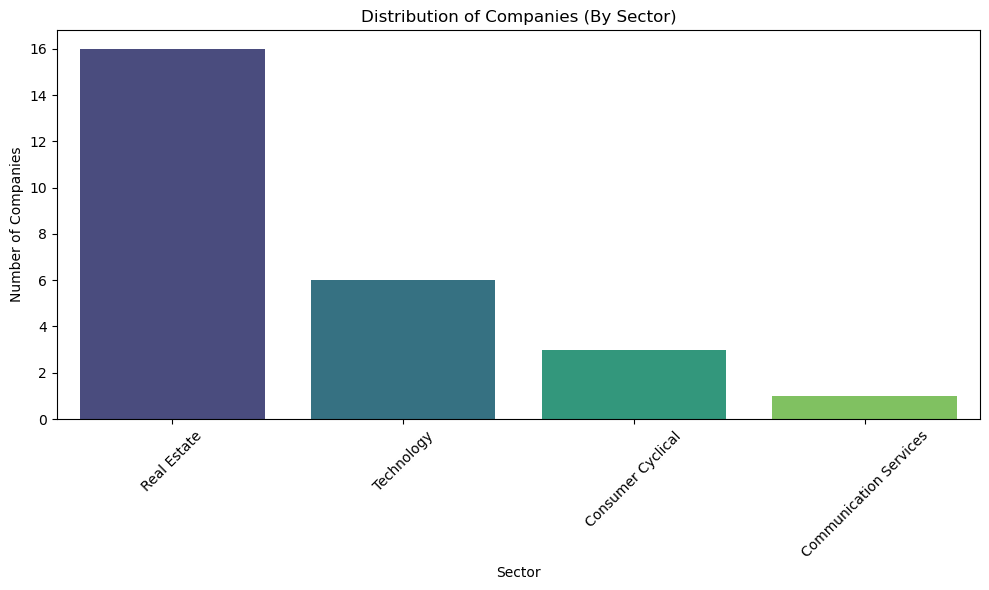

In [326]:
# Count the number of companies in each sector
sector_counts = df_chosen['sector'].value_counts()

# Create a bar chart to display the sector distribution
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=sector_counts.index, y=sector_counts.values, hue=sector_counts.index, palette="viridis", legend=False)  # Plot sector counts
plt.title('Distribution of Companies (By Sector)')  # Set the title
plt.xlabel('Sector')  # Label the x-axis
plt.ylabel('Number of Companies')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()  # Display the plot

### Distribution of Companies (By Industry)
The visualisation focuses on the industry composition of the chosen clusters. The ‘REITs - Residential’ category is the largest followed by ‘Industrial REITs’. This is followed by more REIT industry companies with the only exception being ‘Semiconductor Equipment & Materials'. This is also the only non-REIT industry company to have more than one company in the chosen clusters.

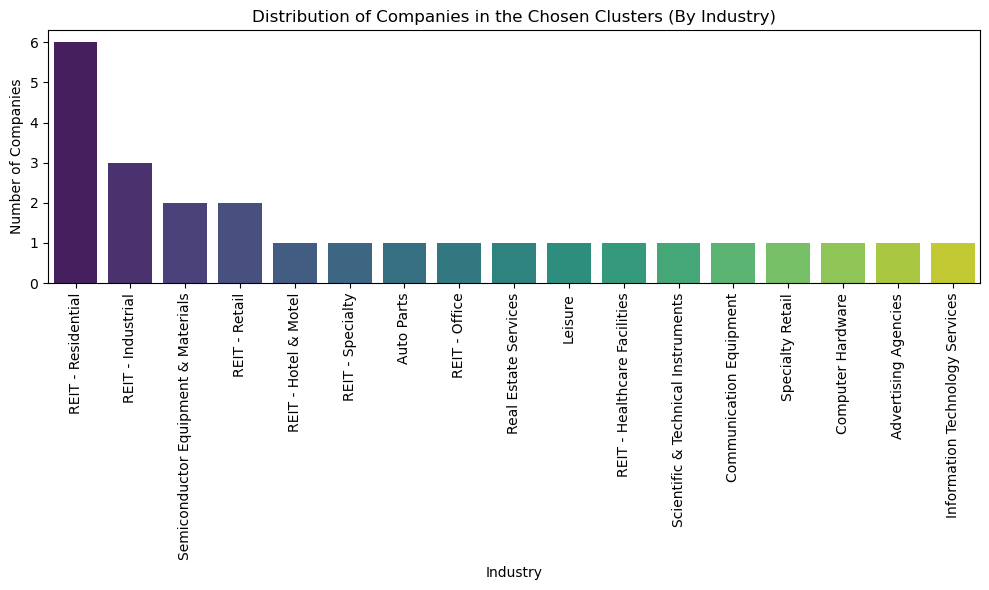

In [324]:
# Count the number of companies in each industry
sector_counts = df_chosen['industry'].value_counts()

# Create a bar chart to display the industry distribution
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=sector_counts.index, y=sector_counts.values, hue=sector_counts.index, palette="viridis", legend=False)  # Plot industry counts
plt.title('Distribution of Companies in the Chosen Clusters (By Industry)')  # Set the title
plt.xlabel('Industry')  # Label the x-axis
plt.ylabel('Number of Companies')  # Label the y-axis
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees for better readability
plt.tight_layout()  # Adjust layout to prevent label clipping
plt.show()  # Display the plot

### Size of Companies (By Employee Count)

The scatterplot plots the number of employees for the given companies. Most of the companies in this cluster have few employees (points much closer to 0 than 100,000) with only very few outliers. This can be validated by the average (51525.23) and median (5572.5) employee counts.

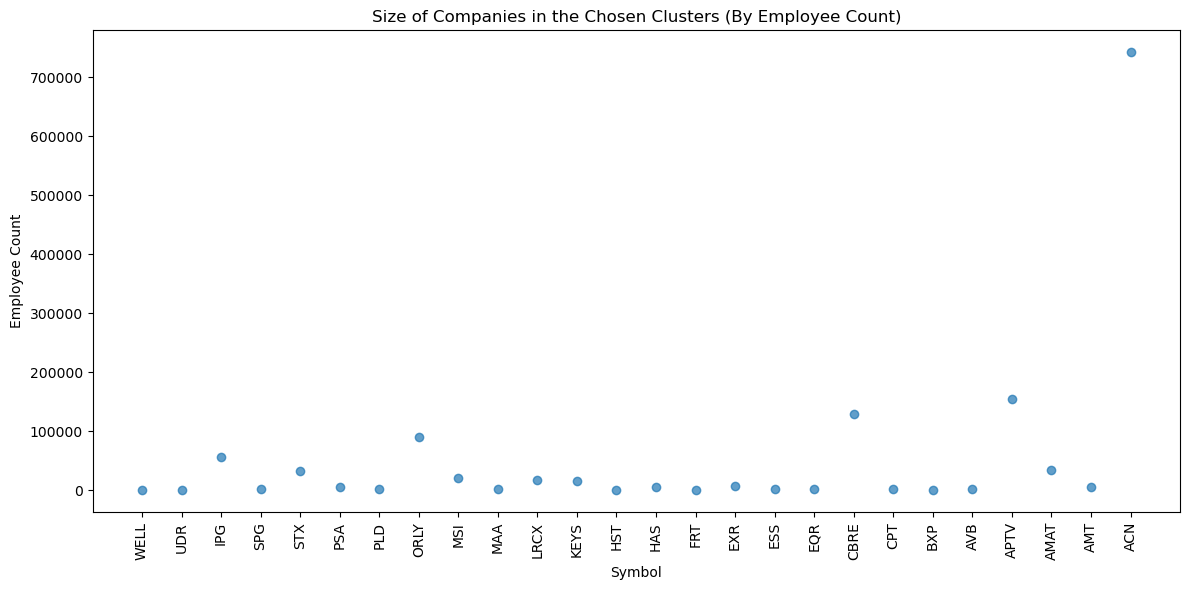

In [314]:
# Create the scatter plot using df_chosen
plt.figure(figsize=(12, 6))  # Set the figure size
plt.scatter(df_chosen['symbol'], df_chosen['employee_count'], alpha=0.7)  # Plot the scatter plot

# Customize the plot
plt.title('Size of Companies in the Chosen Clusters (By Employee Count)')  # Set the plot title
plt.xlabel('Symbol')  # Label the x-axis
plt.ylabel('Employee Count')  # Label the y-axis
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees for better readability
plt.tight_layout()  # Adjust layout to prevent label clipping

# Show the plot
plt.show()  # Display the plot

In [300]:
print("Average Employee Count: "+str(df_chosen['employee_count'].mean()))  # Average employee count
print("Median Employee Count: "+str(df_chosen['employee_count'].median()))  # Median employee count

Average Employee Count: 51525.23
Median Employee Count: 5572.5


### Text Analysis of Descriptions of Companies

The word cloud highlights key themes in the product or service offerings of companies in the selected clusters. Terms like 'services,' 'company,' and 'products' suggest a service focus, while 'network,' 'real estate,' and 'management' indicate key operations such as property management and technology. Frequent mentions of 'solutions' and 'software' emphasise the role of digital services in the companies' strategies.

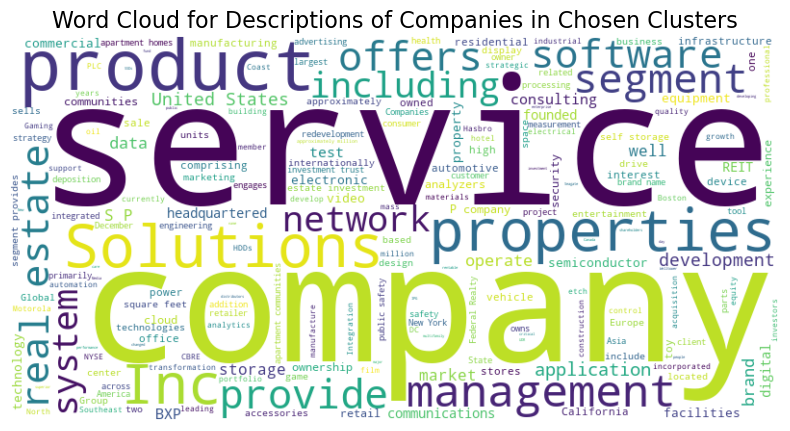

In [312]:
# Combine all text from the 'desc' column into a single string
text = " ".join(df_chosen['desc'].dropna().astype(str))  # Drop missing values, convert to string, and join

# Generate the word cloud
wordcloud = WordCloud(
    width=800,  # Set the width of the word cloud
    height=400,  # Set the height of the word cloud
    background_color='white',  # Set the background colour
    colormap='viridis',  # Set the colour map for the words
    max_words=200  # Limit the number of words to 200
).generate(text)  # Generate the word cloud based on the combined text

# Display the word cloud
plt.figure(figsize=(10, 5))  # Set the figure size
plt.imshow(wordcloud, interpolation='bilinear')  # Display the word cloud with bilinear interpolation
plt.axis('off')  # Turn off axis to focus on the word cloud
plt.title('Word Cloud for Descriptions of Companies in Chosen Clusters', fontsize=16)  # Set the title of the plot
plt.show()  # Display the word cloud

### Variance Analysis of the Risk Scores

This boxplot shows the distribution of ESG risk scores within the chosen clusters. Governance risk scores have the smallest interquartile range, indicating consistent risk across companies, but also the highest maximum and median scores. Environmental risk scores show the widest interquartile range, while social risk scores have moderate variability. If the hedge fund invests in these companies, it may be beneficial to consult specialists for managing governance risk. For environmental risk, given the variance, a broader range of expertise may be useful.

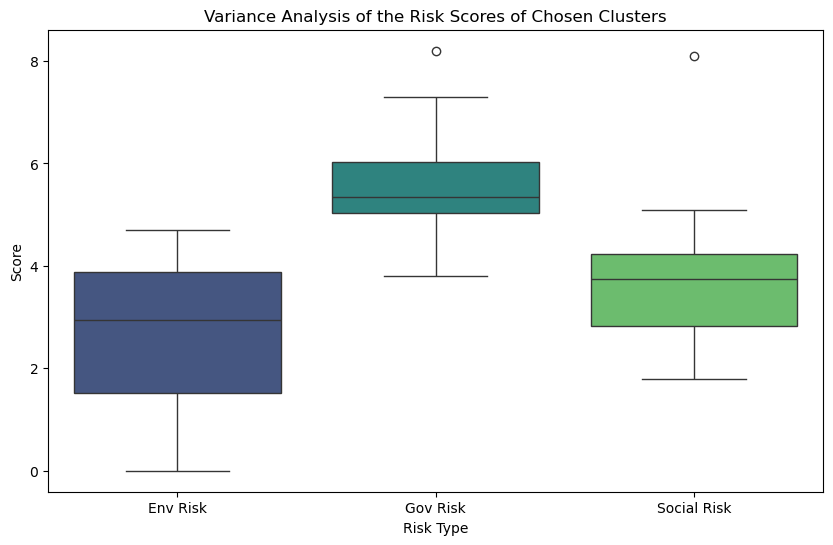

In [322]:
# Filter data for chosen clusters
df_chosen_risk_scores = df_chosen[['env_risk', 'gov_risk', 'social_risk']]

# Melt the DataFrame to reshape it for seaborn boxplot
df_melted = df_chosen_risk_scores.melt(var_name='Risk Type', value_name='Score')

# Create a custom list of labels
risk_labels = ['Env Risk', 'Gov Risk', 'Social Risk']

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Risk Type', y='Score', hue='Risk Type', palette='viridis', legend=False)
plt.title('Variance Analysis of the Risk Scores of Chosen Clusters')
plt.xlabel('Risk Type')
plt.ylabel('Score')

# Change the x-axis labels to custom labels
plt.xticks(ticks=range(3), labels=risk_labels)

plt.show()

# Conclusion and Next Steps

The clustering analysis of 400 companies identified K-Means with 105 clusters as the best model, based on the Silhouette Score, Davies-Bouldin Score, and Calinski-Harabasz Index. This model grouped companies based on a range of dimensions, identifying those with the lowest risk scores and that are close to each other across these dimensions, as explained in the 'Why Machine Learning (ML)' section. The selected companies have average total risk scores between 7.1 and 12.2, which is considered negligible or very low by the publisher of the scores.

This set of companies could be particularly attractive to a hedge fund (usually aiming to preserve the value of its assets, rather than pursue aggressive growth). The next step will involve overlaying financial performance metrics and other indicators onto the clusters to further narrow down the target companies for investment.

# References

<ul>
    <li>Babitz, K. (2023). Introduction to k-Means Clustering with scikit-learn in Python. [online] Datacamp.com. Available at: <a href="https://www.datacamp.com/tutorial/k-means-clustering-python" target="_blank">https://www.datacamp.com/tutorial/k-means-clustering-python</a>.</li>
    <li>Dugar, P. (2023). S&P 500 ESG Risk Ratings. [online] www.kaggle.com. Available at: <a href="https://www.kaggle.com/datasets/pritish509/s-and-p-500-esg-risk-ratings" target="_blank">https://www.kaggle.com/datasets/pritish509/s-and-p-500-esg-risk-ratings</a>.</li>
    <li>Karoui, A. and Zerter, L. (2023). ESG Risk Ratings: A 360° Review In Partnership with Natixis Investment Managers (NIM) Solutions Morningstar | Sustainalytics Natixis Piotr Podgorny, CFA Quant Analyst, NIM Solutions Elpida Louka Quant Analyst, NIM Solutions. [online] Available at: <a href="https://connect.sustainalytics.com/hubfs/INV/Ebooks/ESG%20Risk%20Ratings%20-%20360%20Report%20eBook/MS_ESG_RR_360_Review_Ebook_Final.pdf" target="_blank">https://connect.sustainalytics.com/hubfs/INV/Ebooks/ESG%20Risk%20Ratings%20-%20360%20Report%20eBook/MS_ESG_RR_360_Review_Ebook_Final.pdf</a>.</li>
    <li>Ullah, A., Mohmand, M.I., Hussain, H., Johar, S., Khan, I., Ahmad, S., Mahmoud, H.A. and Huda, S. (2023). Customer Analysis Using Machine Learning-Based Classification Algorithms for Effective Segmentation Using Recency, Frequency, Monetary, and Time. Sensors, [online] 23(6), p.3180. doi: <a href="https://doi.org/10.3390/s23063180" target="_blank">https://doi.org/10.3390/s23063180</a>.</li>
    <li>VanderPlas, J. (2019). In Depth: Gaussian Mixture Models | Python Data Science Handbook. [online] Github.io. Available at: <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html" target="_blank">https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html</a>.</li>
    <li>Yahoo (2024a). Apple Inc. (AAPL) Environment, Social and Governance (ESG) Ratings - Yahoo Finance. [online] finance.yahoo.com. Available at: <a href="https://finance.yahoo.com/quote/AAPL/sustainability/" target="_blank">https://finance.yahoo.com/quote/AAPL/sustainability/</a> [Accessed 3 Nov. 2024].</li>
    <li>Yahoo (2024b). BlackRock, Inc. (BLK) Environment, Social and Governance (ESG) Ratings - Yahoo Finance. [online] Yahoo Finance. Available at: <a href="https://finance.yahoo.com/quote/BLK/sustainability/" target="_blank">https://finance.yahoo.com/quote/BLK/sustainability/</a> [Accessed 3 Nov. 2024].</li>
    <li>Yahoo (2024c). Equinox Gold Corp. (EQX) Environment, Social and Governance (ESG) Ratings - Yahoo Finance. [online] Yahoo Finance. Available at: <a href="https://finance.yahoo.com/quote/EQX/sustainability/" target="_blank">https://finance.yahoo.com/quote/EQX/sustainability/</a> [Accessed 3 Nov. 2024].</li>
    <li>Yang, Y. (2017). Adjusted Rand Index - an overview | ScienceDirect Topics. [online] www.sciencedirect.com. Available at: <a href="https://www.sciencedirect.com/topics/computer-science/adjusted-rand-index" target="_blank">https://www.sciencedirect.com/topics/computer-science/adjusted-rand-index</a>.</li>
</ul>


# Appendix

### Project Management
The team collaborated in person to complete the coding tasks, as the outcomes were interdependent (e.g., data importing and cleaning needed to be done before performing exploratory data analysis, training had to be completed before evaluation, etc.). All team members attended the meetings. Trello was used to track progress, with screenshots taken after each meeting to document the task status. A highly active Teams chat facilitated real-time communication among the team members (screenshots attached). Additionally, the team met regularly with the Teaching Assistant to receive feedback and make improvements (screenshots attached).

<b>Trello</b>

As of Nov 07
![Trello 1](./Images/Trello/Nov-07.png)

As of Nov 11
![Trello 2](./Images/Trello/Nov-11.png)

As of Nov 23
![Trello 3](./Images/Trello/Nov-23.png)

As of Dec 03
![Trello 4](./Images/Trello/Dec-03.png)

As of Dec 06
![Trello 5](./Images/Trello/Dec-06.png)

As of Dec 07
![Trello 6](./Images/Trello/Dec-07.png)

<b>Teams</b>

![Team Meeting Screenshot](./Images/Teams/1.png)

![Team Meeting Screenshot](./Images/Teams/2.png)

![Team Meeting Screenshot](./Images/Teams/3.png)

<b>Meetings with TA</b>

![Meeting TA](./Images/TA1.png)

![Meeting TA](./Images/TA2.png)

### Use of Generative AI

<table border="1">
    <thead>
        <tr>
            <th>Task</th>
            <th>GenAI Usage</th>
            <th>Outcome</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Importing and Cleaning Data</td>
            <td>Generate code to import and clean the dataset <a href="https://chatgpt.com/share/6731eb0e-c69c-800e-a218-d41a4efc8411">https://chatgpt.com/share/6731eb0e-c69c-800e-a218-d41a4efc8411</a></td>
            <td>The dataset was successfully imported and cleaned using the generated code, with no syntax errors encountered.</td>
        </tr>
        <tr>
            <td>Exploratory Data Analysis (EDA)</td>
            <td>Generate code for descriptive analysis and visualisation<a href="https://chatgpt.com/share/6754d53e-f3d8-800e-90fa-3649dc8f451f">https://chatgpt.com/share/6731eb0e-c69c-800e-a218-d41a4efc8411</a></td>
            <td>The suggestions for visualisation were helpful, and the generated code worked well after further clarification was provided.</td>
        </tr>
        <tr>
            <td>Performance Evaluation</td>
            <td>Generate code to evaluate models using appropriate metrics<a href="https://chatgpt.com/share/6754deb3-c470-8004-8758-347aca1fad07">https://chatgpt.com/share/6731eb0e-c69c-800e-a218-d41a4efc8411</a></td>
            <td>Evaluating clustering performance proved challenging, as metrics such as R2 for regression were not directly applicable. GenAI suggested suitable metrics, which were later verified by consulting relevant papers. The code generated for the evaluation was also helpful.</td>
        </tr>
        <tr>
            <td>Data Visualisation</td>
            <td>Generate code for creating various types of visualisations<a href="https://chatgpt.com/share/6753712e-9784-8004-96cb-5e655b633d80">https://chatgpt.com/share/6731eb0e-c69c-800e-a218-d41a4efc8411</a></td>
            <td>The generated code was accurate and produced the intended visualisations. Suggestions to improve the aesthetics of the plots were useful.</td>
        </tr>
    </tbody>
</table>
